In [ ]:
# sub emojis final code
# including num_pos & num_negs

In [1]:
import pandas as pd
import numpy as np
from numpy import random
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from nltk.corpus import stopwords
import gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from scipy import stats
from sklearn.pipeline import Pipeline

import sys
sys.path.insert(0, './readability/')
sys.path.insert(0, './cleaning/')

from readability import Readability 
from text_cleaner import replace_with_regex

sns.set_style("darkgrid")

%matplotlib inline

/Users/seoyeonchang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/seoyeonchang/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### Num_likes

In [4]:
# read csv 
wholefoods = pd.read_csv('./datasets/WholeFoods_facebook_statuses.csv')

# set the name of column of emotions I'll analyze
emotion_type = "num_likes"

# filter extreme outliers (after looking up distribution of the data)
from scipy import stats

def filter_outliers(df, percentage):
    threshold = stats.scoreatpercentile(df[emotion_type], per=percentage)
    new_df = new_df[df[emotion_type] <= threshold]
    return df

outlier_filtered = filter_outliers(wholefoods, 98)

outlier_filtered = fill_na_and_reset_index(outlier_filtered)

# filter out posts with a very small number of likes(cut off: least 2%)
def filter_low_scores(df, percentage):
    least_per = stats.scoreatpercentile(df.num_likes, per=percentage)
    df = df[df.num_likes >= least_per]
    return df

low_score_filtered = filter_low_scores(outlier_filtered, 2)
    
# fill_na_and_reset_index again
low_score_filtered = fill_na_and_reset_index(low_score_filtered)

# fill na and create a combined text column
def df_combine_clean(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)

    # reset index
    df.index = range(df.shape[0])

    # fill na with empty string
    df["status_message"] = df["status_message"].fillna("")
    df["link_name"] = df["link_name"].fillna("")

    # combine 'status messsage' and 'link name' column into 'text column' 
    df["text"] = df["status_message"].map(str) + " " + df["link_name"]

    # clean text column with 'replace_with_regex' function
    # remove numbers, special characters
    df['text'] = df['text'].map(lambda x: replace_with_regex(x))

    return df

text_combine_df = df_combine_clean(low_score_filtered)

# reformulate df with columns relavant for modeling
def reformulate_df(df):
    df = df[['status_type', emotion_type, 'text', 'status_message', 'link_name']]
    return df

df = reformulate_df(text_combine_df)
    

#include more stopwords after looking into the text data for each dataset
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user",
           "aack", "sprouts", "farmers", "market", "com", "brand", "phoenix", "az", "grand", "express", 
            "enter", "win", "timeline", "location", "express", "high", "street", "access", "complete", 
            "winning", "item", "right", "facebook", "photos", "great",  "get", "abc", "sharing", "activity", 
            "year", "acts", "actual", "actually", "yet", "walmart", "better", "black", "www", "first", "everything",
            "store", "back", "tell", "us", "timeline", "cover", "photo", "use", "vary", "pinterest", "able",
           "time" , "tab", "savings", "board", "next", "online", "time", "restrictions", "apply", "like", "timeline", 
            "photos", "kroger", "com", "must", "redeem", "pm", "pt", "redeem", "join", "us", "chance", "win", "tell", 
            "us", "breast", "cancer", "new", "year", "show", "us", "coca", "cola", "january", "th", "oh", "june", 
            "first", "customers", "receive","oz pm pt"]

stop.extend(new_stop)


def create_target(df):
    # mean of num_loves col
    mean = df[emotion_type].mean()
    # create a target column for classification dividing num_loves into 2 classes
    df['target'] = df[emotion_type].map(lambda x: 1 if x > mean else 0)
    return df

df = create_target(df)
    
# fill_na_and_reset_index again
df = fill_na_and_reset_index(df)
    
# I won't use ngram_range for classification because ngrams increases the number of columns 
# more text columns, less accurate prediction

# Tfidf Vectorizer in order to make text sparse matrix
tvt =  TfidfVectorizer(strip_accents='unicode', stop_words = stop)
X_all=  tvt.fit_transform(df["text"])
x_df =  pd.DataFrame(X_all.toarray(), columns=tvt.get_feature_names())

# feature engineering -> create new columns for length of text

# create new columns for length of 2 text columns(status message & link name)
df['len_status_message'] = df['status_message'].map(lambda x: len(x))
df['len_link_name'] = df['link_name'].map(lambda x: len(x))

len_text = df[['len_status_message', 'len_link_name']]

#combine x_df + len_text to create predictor df
df_len_text = pd.concat([x_df, len_text], axis=1)

# fill_na_and_reset_index again
final_df = fill_na_and_reset_index(df_len_text)

final_df['target'] = df.target

df_0 = final_df[final_df.target == 0] 
df_1 = final_df[final_df.target == 1]

assert(df.shape[0] == df_0.shape[0] + df_1.shape[0])

df_1_oversample = df_1.sample(n=df_0.shape[0], replace=True)
# df_0_subsample = df_0.sample(n=df_1.shape[0], replace=True)
df_balanced = df_0.append(df_1_oversample)

# predictors and target
X = df_balanced
y = df_balanced['target']

# train test split
del(X['target'])
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.9, random_state=8)

# LogisticRegression
logreg = LogisticRegression(verbose=1)
logreg.fit(X_train, y_train)
print "logistic regression score: ", logreg.score(X_test, y_test)  # 0.9125

# AdaBoostClassifier using DeicisionClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=50, max_depth=50, random_state=11, max_features=.8, class_weight="balanced")
estimator = AdaBoostClassifier(base_estimator=dc, n_estimators=40, learning_rate=.001)
estimator.fit(X_train, y_train)
print "AdaBoostClassifier Score: ", estimator.score(X_test, y_test) #0.9125

/Users/seoyeonchang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[LibLinear]logistic regression score:  0.801195814649
AdaBoostClassifier Score:  0.823617339312


In [128]:
#classification report
from sklearn.metrics import classification_report, confusion_matrix

predicted = estimator.predict(X_test)
pred_train = estimator.predict(X_train)
clfr = classification_report(y_test, predicted)
clfr_train = classification_report(y_train, pred_train)
print clfr
print "-------------------",
print clfr_train


             precision    recall  f1-score   support

          0       0.90      0.76      0.82       351
          1       0.77      0.91      0.84       318

avg / total       0.84      0.83      0.83       669

-------------------              precision    recall  f1-score   support

          0       0.92      0.88      0.90      2991
          1       0.88      0.93      0.91      3024

avg / total       0.90      0.90      0.90      6015



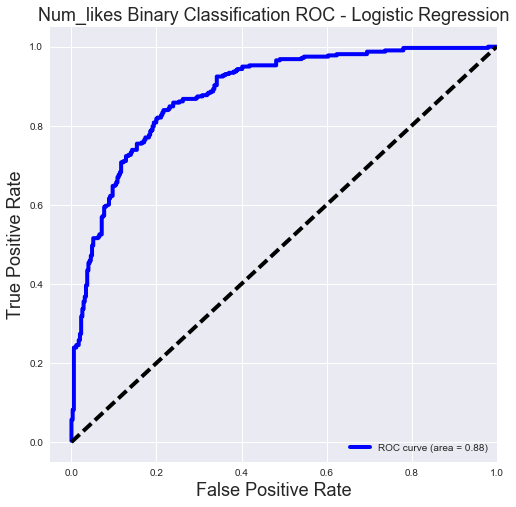

In [129]:
y_score = logreg.predict_proba(X_test)

# ROC 
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, color = 'blue', label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Num_likes Binary Classification ROC - Logistic Regression', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Positive vs negative Reactions

### Positive reactions

In [2]:
# read csv 
wholefoods = pd.read_csv('./datasets/WholeFoods_facebook_statuses.csv')

# create a new columns called num_of_pos which sums up the total number of positive reactions 
def create_num_pos_col(df):
    df['num_pos'] = df['num_loves'] + df['num_hahas'] + df['num_wows']
    return df

wholefoods_pos = create_num_pos_col(wholefoods)

# set the name of column of emotions I'll analyze
emotion_type = "num_pos"

# cut out rows before Mar 2016 when Facebook included various sub emojies 
# such as loves, wows, hahas, sads, angrys
# in order to analyze the relationship between those emojis and texts
import datetime as dt

def filter_out_before_march_2016(df):
    # transform 'status_published' column into datetime object
    df['status_published'] = pd.to_datetime(df['status_published'])
    # create new columns for year and month 
    df['year'] = df['status_published'].dt.year
    df['month'] = df['status_published'].dt.month
    # filter out rows before March 2016
    df = df[df['year'] > 2016]
    df = df[df['month'] >= 3]
    return df

date_filtered = filter_out_before_march_2016(wholefoods_pos)

def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)
    # reset index
    df.index = range(df.shape[0])
    return df

date_filtered = fill_na_and_reset_index(date_filtered)

# filter extreme outliers (after looking up distribution of the data)
from scipy import stats

def filter_outliers(df, percentage):
    threshold = stats.scoreatpercentile(df[emotion_type], per=percentage)
    df = df[df[emotion_type] <= threshold]
    return df

outlier_filtered = filter_outliers(wholefoods, 98)

# fill_na_and_reset_index 
def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)
    # reset index
    df.index = range(df.shape[0])
    return df

outlier_filtered = fill_na_and_reset_index(outlier_filtered)

# filter out posts with a very small number of likes(cut off: least 2%)
def filter_low_scores(df, percentage):
    least_per = stats.scoreatpercentile(df.num_likes, per=percentage)
    df = df[df.num_likes >= least_per]
    return df

low_score_filtered = filter_low_scores(outlier_filtered, 0)
    
# fill_na_and_reset_index again
low_score_filtered = fill_na_and_reset_index(low_score_filtered)

# fill na and create a combined text column
def df_combine_clean(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)

    # reset index
    df.index = range(df.shape[0])

    # fill na with empty string
    df["status_message"] = df["status_message"].fillna("")
    df["link_name"] = df["link_name"].fillna("")

    # combine 'status messsage' and 'link name' column into 'text column' 
    df["text"] = df["status_message"].map(str) + " " + df["link_name"]

    # clean text column with 'replace_with_regex' function
    # remove numbers, special characters
    df['text'] = df['text'].map(lambda x: replace_with_regex(x))

    return df

text_combine_df = df_combine_clean(low_score_filtered)

# reformulate df with columns relavant for modeling
def reformulate_df(df):
    df = df[['status_type', emotion_type, 'text', 'status_message', 'link_name']]
    return df

df = reformulate_df(text_combine_df)
    

#include more stopwords after looking into the text data for each dataset
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user",
           "aack", "sprouts", "farmers", "market", "com", "brand", "phoenix", "az", "grand", "express", 
            "enter", "win", "timeline", "location", "express", "high", "street", "access", "complete", 
            "winning", "item", "right", "facebook", "photos", "great",  "get", "abc", "sharing", "activity", 
            "year", "acts", "actual", "actually", "yet", "walmart", "better", "black", "www", "first", "everything",
            "store", "back", "tell", "us", "timeline", "cover", "photo", "use", "vary", "pinterest", "able",
           "time" , "tab", "savings", "board", "next", "online", "time", "restrictions", "apply", "like", "timeline", 
            "photos", "kroger", "com", "must", "redeem", "pm", "pt", "redeem", "join", "us", "chance", "win", "tell", 
            "us", "breast", "cancer", "new", "year", "show", "us", "coca", "cola", "january", "th", "oh", "june", 
            "first", "customers", "receive","oz pm pt"]

stop.extend(new_stop)


def create_target(df):
    # mean of num_loves col
    mean = df[emotion_type].mean()
    # create a target column for classification dividing num_loves into 2 classes
    df['target'] = df[emotion_type].map(lambda x: 1 if x > mean else 0)
    return df

df = create_target(df)
    
# fill_na_and_reset_index again
df = fill_na_and_reset_index(df)
    
# I won't use ngram_range for classification because ngrams increases the number of columns 
# more text columns, less accurate prediction

# Tfidf Vectorizer in order to make text sparse matrix
tvt =  TfidfVectorizer(strip_accents='unicode', stop_words = stop)
X_all=  tvt.fit_transform(df["text"])
x_df =  pd.DataFrame(X_all.toarray(), columns=tvt.get_feature_names())

# feature engineering -> create new columns for length of text

# create new columns for length of 2 text columns(status message & link name)
df['len_status_message'] = df['status_message'].map(lambda x: len(x))
df['len_link_name'] = df['link_name'].map(lambda x: len(x))

len_text = df[['len_status_message', 'len_link_name']]

#combine x_df + len_text to create predictor df
df_len_text = pd.concat([x_df, len_text], axis=1)

# fill_na_and_reset_index again
final_df = fill_na_and_reset_index(df_len_text)

final_df['target'] = df.target

df_0 = final_df[final_df.target == 0] 
df_1 = final_df[final_df.target == 1]

assert(df.shape[0] == df_0.shape[0] + df_1.shape[0])

df_1_oversample = df_1.sample(n=df_0.shape[0], replace=True)
# df_0_subsample = df_0.sample(n=df_1.shape[0], replace=True)
df_balanced = df_0.append(df_1_oversample)

# predictors and target
X = df_balanced
y = df_balanced['target']

# train test split
del(X['target'])
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.7, random_state=8)

# LogisticRegression
logreg = LogisticRegression(verbose=1)
logreg.fit(X_train, y_train)
print "logistic regression score: ", logreg.score(X_test, y_test)  # 0.9125

# AdaBoostClassifier using DeicisionClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=50, max_depth=50, random_state=11, max_features=.8, class_weight="balanced")
estimator = AdaBoostClassifier(base_estimator=dc, n_estimators=40, learning_rate=.001)
estimator.fit(X_train, y_train)
print "AdaBoostClassifier Score: ", estimator.score(X_test, y_test) #0.9125

/Users/seoyeonchang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[LibLinear]logistic regression score:  0.956471494607
AdaBoostClassifier Score:  0.972650231125


In [25]:
#classification report
from sklearn.metrics import classification_report, confusion_matrix

predicted = logreg.predict(X_test)
clfr = classification_report(y_test, predicted)

print clfr

             precision    recall  f1-score   support

          0       0.98      0.93      0.95      1341
          1       0.93      0.98      0.95      1255

avg / total       0.95      0.95      0.95      2596



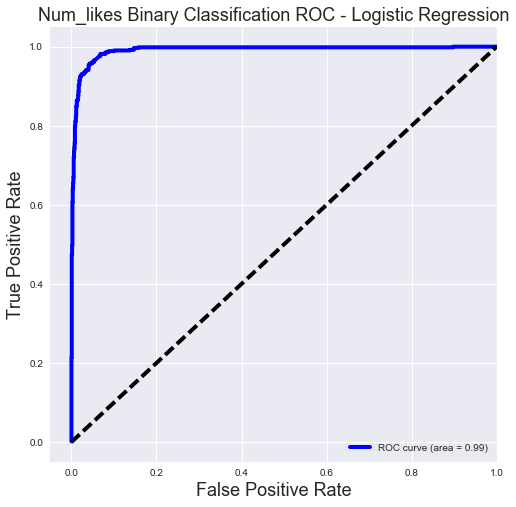

In [26]:
y_score = logreg.predict_proba(X_test)

# ROC 
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, color = 'blue', label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Num_likes Binary Classification ROC - Logistic Regression', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Negative reactions

In [3]:
# read csv 
wholefoods = pd.read_csv('./datasets/WholeFoods_facebook_statuses.csv')

# create a new columns called num_of_negs which sums up the total number of negative reactions 
def create_num_negs_col(df):
    df['num_negs'] = df['num_sads'] + df['num_angrys'] 
    return df

wholefoods_pos = create_num_negs_col(wholefoods)

# set the name of column of emotions I'll analyze
emotion_type = "num_negs"

# cut out rows before Mar 2016 when Facebook included various sub emojies 
# such as loves, wows, hahas, sads, angrys
# in order to analyze the relationship between those emojis and texts
import datetime as dt

def filter_out_before_march_2016(df):
    # transform 'status_published' column into datetime object
    df['status_published'] = pd.to_datetime(df['status_published'])
    # create new columns for year and month 
    df['year'] = df['status_published'].dt.year
    df['month'] = df['status_published'].dt.month
    # filter out rows before March 2016
    df = df[df['year'] > 2016]
    df = df[df['month'] >= 3]
    return df

date_filtered = filter_out_before_march_2016(wholefoods_pos)

def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)
    # reset index
    df.index = range(df.shape[0])
    return df

date_filtered = fill_na_and_reset_index(date_filtered)

# filter extreme outliers (after looking up distribution of the data)
from scipy import stats

def filter_outliers(df, percentage):
    threshold = stats.scoreatpercentile(df[emotion_type], per=percentage)
    df = df[df[emotion_type] <= threshold]
    return df

outlier_filtered = filter_outliers(wholefoods, 98)

# fill_na_and_reset_index 
def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)
    # reset index
    df.index = range(df.shape[0])
    return df

outlier_filtered = fill_na_and_reset_index(outlier_filtered)

# filter out posts with a very small number of likes(cut off: least 2%)
def filter_low_scores(df, percentage):
    least_per = stats.scoreatpercentile(df.num_likes, per=percentage)
    df = df[df.num_likes >= least_per]
    return df

low_score_filtered = filter_low_scores(outlier_filtered, 0)
    
# fill_na_and_reset_index again
low_score_filtered = fill_na_and_reset_index(low_score_filtered)

# fill na and create a combined text column
def df_combine_clean(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)

    # reset index
    df.index = range(df.shape[0])

    # fill na with empty string
    df["status_message"] = df["status_message"].fillna("")
    df["link_name"] = df["link_name"].fillna("")

    # combine 'status messsage' and 'link name' column into 'text column' 
    df["text"] = df["status_message"].map(str) + " " + df["link_name"]

    # clean text column with 'replace_with_regex' function
    # remove numbers, special characters
    df['text'] = df['text'].map(lambda x: replace_with_regex(x))

    return df

text_combine_df = df_combine_clean(low_score_filtered)

# reformulate df with columns relavant for modeling
def reformulate_df(df):
    df = df[['status_type', emotion_type, 'text', 'status_message', 'link_name']]
    return df

df = reformulate_df(text_combine_df)
    

#include more stopwords after looking into the text data for each dataset
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user",
           "aack", "sprouts", "farmers", "market", "com", "brand", "phoenix", "az", "grand", "express", 
            "enter", "win", "timeline", "location", "express", "high", "street", "access", "complete", 
            "winning", "item", "right", "facebook", "photos", "great",  "get", "abc", "sharing", "activity", 
            "year", "acts", "actual", "actually", "yet", "walmart", "better", "black", "www", "first", "everything",
            "store", "back", "tell", "us", "timeline", "cover", "photo", "use", "vary", "pinterest", "able",
           "time" , "tab", "savings", "board", "next", "online", "time", "restrictions", "apply", "like", "timeline", 
            "photos", "kroger", "com", "must", "redeem", "pm", "pt", "redeem", "join", "us", "chance", "win", "tell", 
            "us", "breast", "cancer", "new", "year", "show", "us", "coca", "cola", "january", "th", "oh", "june", 
            "first", "customers", "receive","oz pm pt"]

stop.extend(new_stop)


def create_target(df):
    # mean of num_loves col
    mean = df[emotion_type].mean()
    # create a target column for classification dividing num_loves into 2 classes
    df['target'] = df[emotion_type].map(lambda x: 1 if x > mean else 0)
    return df

df = create_target(df)
    
# fill_na_and_reset_index again
df = fill_na_and_reset_index(df)
    
# I won't use ngram_range for classification because ngrams increases the number of columns 
# more text columns, less accurate prediction

# Tfidf Vectorizer in order to make text sparse matrix
tvt =  TfidfVectorizer(strip_accents='unicode', stop_words = stop)
X_all=  tvt.fit_transform(df["text"])
x_df =  pd.DataFrame(X_all.toarray(), columns=tvt.get_feature_names())

# feature engineering -> create new columns for length of text

# create new columns for length of 2 text columns(status message & link name)
df['len_status_message'] = df['status_message'].map(lambda x: len(x))
df['len_link_name'] = df['link_name'].map(lambda x: len(x))

len_text = df[['len_status_message', 'len_link_name']]

#combine x_df + len_text to create predictor df
df_len_text = pd.concat([x_df, len_text], axis=1)

# fill_na_and_reset_index again
final_df = fill_na_and_reset_index(df_len_text)

final_df['target'] = df.target

df_0 = final_df[final_df.target == 0] 
df_1 = final_df[final_df.target == 1]

assert(df.shape[0] == df_0.shape[0] + df_1.shape[0])

df_1_oversample = df_1.sample(n=df_0.shape[0], replace=True)
# df_0_subsample = df_0.sample(n=df_1.shape[0], replace=True)
df_balanced = df_0.append(df_1_oversample)

# predictors and target
X = df_balanced
y = df_balanced['target']

# train test split
del(X['target'])
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.7, random_state=8)

# LogisticRegression
logreg = LogisticRegression(verbose=1)
logreg.fit(X_train, y_train)
print "logistic regression score: ", logreg.score(X_test, y_test)  # 0.9125

# AdaBoostClassifier using DeicisionClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=50, max_depth=50, random_state=11, max_features=.8, class_weight="balanced")
estimator = AdaBoostClassifier(base_estimator=dc, n_estimators=40, learning_rate=.001)
estimator.fit(X_train, y_train)
print "AdaBoostClassifier Score: ", estimator.score(X_test, y_test) #0.9125

/Users/seoyeonchang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[LibLinear]logistic regression score:  0.979815864023
AdaBoostClassifier Score:  0.988668555241


In [28]:
#classification report
from sklearn.metrics import classification_report, confusion_matrix

predicted = logreg.predict(X_test)
clfr = classification_report(y_test, predicted)

print clfr

             precision    recall  f1-score   support

          0       1.00      0.96      0.98      1436
          1       0.96      1.00      0.98      1388

avg / total       0.98      0.98      0.98      2824



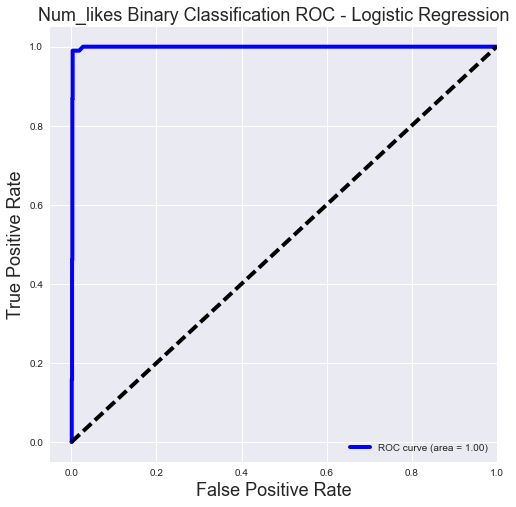

In [29]:
y_score = logreg.predict_proba(X_test)

# ROC 
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, color = 'blue', label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Num_likes Binary Classification ROC - Logistic Regression', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [30]:
for i in zip(predicted[:20], y_test):
    print(i)

(0, 0)
(0, 0)
(0, 0)
(0, 0)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(0, 0)
(1, 1)
(1, 1)
(0, 0)
(1, 1)
(0, 0)
(1, 1)
(1, 1)
(0, 0)
(0, 0)


## Keyword Extraction(num_likes + num_pos)

In [36]:
# read csv 
wholefoods = pd.read_csv('./datasets/WholeFoods_facebook_statuses.csv')

# create a new columns called num_of_pos which sums up the total number of positive reactions 
def create_num_pos_col(df):
    df['num_likes_pos'] = df['num_likes'] + df['num_loves'] + df['num_hahas'] + df['num_wows']
    return df

wholefoods = create_num_pos_col(wholefoods)

# set the name of column of emotions I'll analyze
emotion_type = "num_likes_pos"

# filter extreme outliers (after looking up distribution of the data)
from scipy import stats

def filter_outliers(df, percentage):
    threshold = stats.scoreatpercentile(df[emotion_type], per=percentage)
    df = df[df[emotion_type] <= threshold]
    return df

outlier_filtered = filter_outliers(wholefoods, 98)

# fill_na_and_reset_index 
def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)
    # reset index
    df.index = range(df.shape[0])
    return df

outlier_filtered = fill_na_and_reset_index(outlier_filtered)

# filter out posts with a very small number of likes(cut off: least 2%)
def filter_low_scores(df, percentage):
    least_per = stats.scoreatpercentile(df.num_likes, per=percentage)
    df = df[df.num_likes >= least_per]
    return df

low_score_filtered = filter_low_scores(outlier_filtered, 2)
    
# fill_na_and_reset_index again
low_score_filtered = fill_na_and_reset_index(low_score_filtered)

# fill na and create a combined text column
def df_combine_clean(df):
    # fillna with ""(empty string)
    df = df.replace(np.nan,'', regex=True)

    # reset index
    df.index = range(df.shape[0])

    # fill na with empty string
    df["status_message"] = df["status_message"].fillna("")
    df["link_name"] = df["link_name"].fillna("")

    # combine 'status messsage' and 'link name' column into 'text column' 
    df["text"] = df["status_message"].map(str) + " " + df["link_name"]

    # clean text column with 'replace_with_regex' function
    # remove numbers, special characters
    df['text'] = df['text'].map(lambda x: replace_with_regex(x))

    return df

text_combine_df = df_combine_clean(low_score_filtered)

# reformulate df with columns relavant for modeling
def reformulate_df(df):
    df = df[['status_type', emotion_type, 'text', 'status_message', 'link_name']]
    return df

df = reformulate_df(text_combine_df)
    

#include more stopwords after looking into the text data for each dataset
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user",
           "aack", "sprouts", "farmers", "market", "com", "brand", "phoenix", "az", "grand", "express", 
            "enter", "win", "timeline", "location", "express", "high", "street", "access", "complete", 
            "winning", "item", "right", "facebook", "photos", "great",  "get", "abc", "sharing", "activity", 
            "year", "acts", "actual", "actually", "yet", "walmart", "better", "black", "www", "first", "everything",
            "store", "back", "tell", "us", "timeline", "cover", "photo", "use", "vary", "pinterest", "able",
           "time" , "tab", "savings", "board", "next", "online", "time", "restrictions", "apply", "like", "timeline", 
            "photos", "kroger", "com", "must", "redeem", "pm", "pt", "redeem", "join", "us", "chance", "win", "tell", 
            "us", "breast", "cancer", "new", "year", "show", "us", "coca", "cola", "january", "th", "oh", "june", 
            "first", "customers", "receive","oz pm pt"]

stop.extend(new_stop)

def create_target(df):
    # mean of num_loves col
    mean = df[emotion_type].mean()
    # create a target column for classification dividing num_loves into 2 classes
    df['target'] = df[emotion_type].map(lambda x: 1 if x > mean else 0)
    return df

df = create_target(df)
    
# fill_na_and_reset_index again
df = fill_na_and_reset_index(df)
    
# I won't use ngram_range for classification because ngrams increases the number of columns 
# more text columns, less accurate prediction

# Tfidf Vectorizer in order to make text sparse matrix
tvt =  TfidfVectorizer(strip_accents='unicode', stop_words = stop)
X_all=  tvt.fit_transform(df["text"])
x_df =  pd.DataFrame(X_all.toarray(), columns=tvt.get_feature_names())

# feature engineering -> create new columns for length of text

# create new columns for length of 2 text columns(status message & link name)
df['len_status_message'] = df['status_message'].map(lambda x: len(x))
df['len_link_name'] = df['link_name'].map(lambda x: len(x))

len_text = df[['len_status_message', 'len_link_name']]

#combine x_df + len_text to create predictor df
df_len_text = pd.concat([x_df, len_text], axis=1)

# fill_na_and_reset_index again
final_df = fill_na_and_reset_index(df_len_text)

final_df['target'] = df.target

df_0 = final_df[final_df.target == 0] 
df_1 = final_df[final_df.target == 1]

assert(df.shape[0] == df_0.shape[0] + df_1.shape[0])

df_1_oversample = df_1.sample(n=df_0.shape[0], replace=True)
# df_0_subsample = df_0.sample(n=df_1.shape[0], replace=True)
df_balanced = df_0.append(df_1_oversample)

# predictors and target
X = df_balanced
y = df_balanced['target']

# train test split
del(X['target'])
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.7, random_state=8)

# LogisticRegression
logreg = LogisticRegression(verbose=1)
logreg.fit(X_train, y_train)
print "logistic regression score: ", logreg.score(X_test, y_test)  # 0.9125

# AdaBoostClassifier using DeicisionClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(random_state=11, max_features = "auto", class_weight = "balanced", max_depth = 18)
estimator = AdaBoostClassifier(base_estimator = dc, n_estimators=120, learning_rate=.5)
estimator.fit(X_train, y_train)
print "AdaBoostClassifier Score: ", estimator.score(X_test, y_test) #0.9125

/Users/seoyeonchang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[LibLinear]logistic regression score:  0.766350474289
AdaBoostClassifier Score:  0.866699950075
